In [1]:
cd '/Users/rabarry/Documents/Insight/NYC data'

/Users/rabarry/Documents/Insight/NYC data


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns

# Initial data cleaning

In [3]:
HD = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [4]:
#cast date as date datatype
HD["INSPECTION DATE"] = pd.to_datetime(HD["INSPECTION DATE"])

In [5]:
#remove anything before 01-01-2014
HD = HD[HD["INSPECTION DATE"] > '2014-01-01']

In [6]:
HD = HD.sort_values("INSPECTION DATE")

In [7]:
len(HD["CAMIS"].unique())

25697

In [8]:
HD["CRITICAL FLAG"].value_counts()

Y    217897
N    171818
Name: CRITICAL FLAG, dtype: int64

In [13]:
HD.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

# Recode critical flag so we can get a count of Y and N

In [43]:
def recode_critical (row):
    if row["CRITICAL FLAG"] == "Y":
        return 1
    else:
        return 0

In [44]:
HD['critical_flag_recode'] = HD.apply (lambda row: recode_critical(row), axis=1)

# Group by Restaurant and Inspection Date

In [45]:
HD_grouped = HD.groupby(["CAMIS", "INSPECTION DATE"]).agg({'critical_flag_recode': 'sum'})
HD_grouped.reset_index()
HD_grouped.head()
HD_grouped.tail()

,CAMIS,INSPECTION DATE,critical_flag_recode
0,30075445,2017-05-18,1
1,30075445,2018-05-11,0
2,30075445,2019-05-16,1
3,30075445,2019-06-11,0
4,30075445,2019-10-21,2
...,...,...,...
134435,50101998,2020-01-07,1
134436,50102076,2020-01-07,3
134437,50102276,2020-01-09,3
134438,50102300,2020-01-07,6


critical_flag_recode
CAMIS    INSPECTION DATE                      
30075445 2017-05-18                          1
         2018-05-11                          0
         2019-05-16                          1
         2019-06-11                          0
         2019-10-21                          2

,,critical_flag_recode
CAMIS,INSPECTION DATE,
50101998,2020-01-07,1
50102076,2020-01-07,3
50102276,2020-01-09,3
50102300,2020-01-07,6
50102397,2020-01-09,1


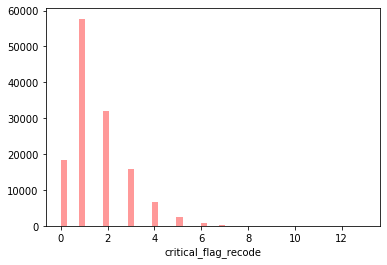

In [65]:
#pd.DataFrame.hist(HD_grouped)
sns.distplot(HD_grouped, kde=False, color='r')

# Group by cuisine type

In [84]:
HD_grouped_byCuisine = HD.groupby("CUISINE DESCRIPTION").agg({"critical_flag_recode":'sum', 'CAMIS':'count'})
HD_grouped_byCuisine=HD_grouped_byCuisine.reset_index()
HD_grouped_byCuisine['AVG_flags']= HD_grouped_byCuisine["critical_flag_recode"]/HD_grouped_byCuisine['CAMIS']
HD_grouped_byCuisine= HD_grouped_byCuisine.sort_values('CAMIS')
HD_grouped_byCuisine.head()
HD_grouped_byCuisine.tail()

,CUISINE DESCRIPTION,critical_flag_recode,CAMIS,AVG_flags
10,Basque,3,7,0.428571
18,Chilean,19,34,0.558824
25,Czech,23,41,0.560976
57,Nuts/Confectionary,15,43,0.348837
56,Not Listed/Not Applicable,35,64,0.546875


,CUISINE DESCRIPTION,critical_flag_recode,CAMIS,AVG_flags
51,"Latin (Cuban, Dominican, Puerto Rican, South &...",9945,17419,0.570928
62,Pizza,9564,17515,0.546046
13,Café/Coffee/Tea,9772,19420,0.503193
19,Chinese,24036,41896,0.573706
2,American,45029,83710,0.537917


(0.2, 0.6)

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Average number of flags in the Top 5 most popular restaurant types')

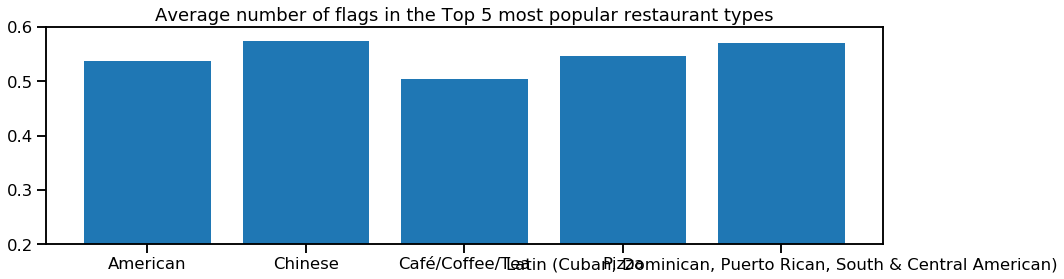

In [85]:
fig = plt.figure(figsize=(15,4))
plt.ylim(0.2,0.6)
HD_top5 = HD_grouped_byCuisine.nlargest(5,columns='CAMIS')
plt.bar(HD_top5["CUISINE DESCRIPTION"],HD_top5["AVG_flags"])
plt.title("Average number of flags in the Top 5 most popular restaurant types")

# Group by Restaurant

Text(0.5, 1.0, 'Total Number of Critical Violations')

(0, 40)

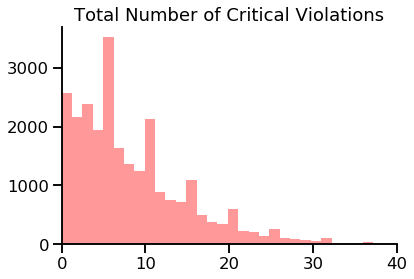

In [89]:
HD_grouped_allDates = HD.groupby("CAMIS").agg({'critical_flag_recode': 'sum'})
#HD_grouped_allDates = HD_grouped_allDates.reset_index()
sns.set_context("talk")
sns.distplot(HD_grouped_allDates, kde=False, color='r')
sns.despine()
#plt.xlabel('Number of Critical Violations')
plt.title('Total Number of Critical Violations')
plt.xlim(0,40) 
#plt.savefig('histogram.png')

# create a list to use for searching yelp

In [91]:
yelp_list = HD[['CAMIS', 'DBA', 'BORO', 'ZIPCODE', 'PHONE', 'Latitude', 'Longitude']]
#remove duplicates
yelp_list_stripped = yelp_list.drop_duplicates(['CAMIS'])
yelp_list_stripped.head()

,CAMIS,DBA,BORO,ZIPCODE,PHONE,Latitude,Longitude
13541,50003303,BROOKLYN SWEET SPOT,Brooklyn,11205.0,7185222577,40.693184,-73.971562
4045,41308050,RELISH CONCESSIONS (LASKER RINK),Manhattan,NaN,9174923856,0.000000,0.000000
388145,41702635,KAPPOCK CAFE,Bronx,10463.0,7186015500,40.878731,-73.917529
140010,50012569,CASA MEXICANA,Manhattan,10025.0,2122223151,40.799035,-73.966742
231232,50000233,PALM COURT,Manhattan,10019.0,2127593000,40.764148,-73.973951


In [10]:
len(yelp_list['CAMIS'].unique())
len(yelp_list_stripped)
type(yelp_list_stripped)

25697

25697

pandas.core.frame.DataFrame

# Do some cleaning for yelp search

In [92]:
yelp_list_stripped['Latitude'].value_counts()
yelp_list_stripped['Longitude'].value_counts()
yelp_list_stripped['Latitude']=yelp_list_stripped['Latitude'].fillna(0)
yelp_list_stripped['Longitude']=yelp_list_stripped['Longitude'].fillna(0)
yelp_list_stripped['DBA_clean'] = yelp_list_stripped['DBA'].str.split('#').str[0] 
yelp_list_stripped.head()

0.000000     399
40.648313    118
40.750655     67
40.774414     61
40.829028     45
            ... 
40.610341      1
40.713265      1
40.735671      1
40.725661      1
40.737156      1
Name: Latitude, Length: 21746, dtype: int64

 0.000000     399
-73.788281    118
-73.991944     67
-73.877293     61
-73.928496     45
             ... 
-73.877641      1
-73.935739      1
-73.955130      1
-73.954514      1
-73.707634      1
Name: Longitude, Length: 21746, dtype: int64

/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,CAMIS,DBA,BORO,ZIPCODE,PHONE,Latitude,Longitude,DBA_clean
13541,50003303,BROOKLYN SWEET SPOT,Brooklyn,11205.0,7185222577,40.693184,-73.971562,BROOKLYN SWEET SPOT
4045,41308050,RELISH CONCESSIONS (LASKER RINK),Manhattan,NaN,9174923856,0.000000,0.000000,RELISH CONCESSIONS (LASKER RINK)
388145,41702635,KAPPOCK CAFE,Bronx,10463.0,7186015500,40.878731,-73.917529,KAPPOCK CAFE
140010,50012569,CASA MEXICANA,Manhattan,10025.0,2122223151,40.799035,-73.966742,CASA MEXICANA
231232,50000233,PALM COURT,Manhattan,10019.0,2127593000,40.764148,-73.973951,PALM COURT


In [22]:
test=yelp_list_stripped[yelp_list_stripped['CAMIS']==50050805]
test

,CAMIS,DBA,BORO,ZIPCODE,PHONE,Latitude,Longitude,DBA_clean
218782,50050805,#1 Chinese Restaurant,Manhattan,10033.0,2127403188,40.851256,-73.939519,


In [23]:
yelp_list_stripped.to_csv(r'Restaurant_List.csv')

# Testing stuff

In [24]:
test = test[test["Longitude"] < 0]

In [25]:
test['Latitude'].min()
test['Latitude'].max()
test['Longitude'].min()
test['Longitude'].max()

40.508068517904

40.912822326386

-74.248434473464

-73.700928057808

In [93]:
test=HD[HD['CAMIS']==50063056]

In [94]:
test.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,critical_flag_recode
270396,50063056,MASPETH CAFETERIA,Queens,4805,GRAND AVE,11378.0,2016388280,American,2017-05-18,Violations were cited in the following area(s).,...,Administrative Miscellaneous / Initial Inspection,40.717286,-73.919782,405.0,30.0,21900.0,4058955.0,4.026020e+09,QN31,0
91705,50063056,MASPETH CAFETERIA,Queens,4805,GRAND AVE,11378.0,2016388280,American,2017-05-18,Establishment Closed by DOHMH. Violations wer...,...,Pre-permit (Operational) / Initial Inspection,40.717286,-73.919782,405.0,30.0,21900.0,4058955.0,4.026020e+09,QN31,1
253835,50063056,MASPETH CAFETERIA,Queens,4805,GRAND AVE,11378.0,2016388280,American,2017-05-18,Establishment Closed by DOHMH. Violations wer...,...,Pre-permit (Operational) / Initial Inspection,40.717286,-73.919782,405.0,30.0,21900.0,4058955.0,4.026020e+09,QN31,1
328245,50063056,MASPETH CAFETERIA,Queens,4805,GRAND AVE,11378.0,2016388280,American,2017-05-18,Establishment Closed by DOHMH. Violations wer...,...,Pre-permit (Operational) / Initial Inspection,40.717286,-73.919782,405.0,30.0,21900.0,4058955.0,4.026020e+09,QN31,1
93577,50063056,MASPETH CAFETERIA,Queens,4805,GRAND AVE,11378.0,2016388280,American,2017-05-18,Establishment Closed by DOHMH. Violations wer...,...,Pre-permit (Operational) / Initial Inspection,40.717286,-73.919782,405.0,30.0,21900.0,4058955.0,4.026020e+09,QN31,1


# Test out timestamp differences

In [38]:
HD_time = HD.sort_values(by=['CAMIS', 'INSPECTION DATE'])

In [39]:
HD_time['time_diff'] = HD_time.groupby('CAMIS')['INSPECTION DATE'].diff()

In [40]:
HD_time.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,time_diff
299101,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2017-05-18,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37,NaT
294488,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2017-05-18,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37,0 days
60658,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2018-05-11,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37,358 days
123567,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2018-05-11,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37,0 days
387953,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVE,10462.0,7188924968,Bakery,2019-05-16,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.848231,-73.855972,211.0,13.0,25200.0,2045445.0,2.041270e+09,BX37,370 days


# Number of Critical Violations at Most Recent Inspection

In [110]:
#HD_LastInsp = HD.sort_values('INSPECTION DATE').groupby('CAMIS').last()
HD_LastInsp = HD.sort_values('INSPECTION DATE').groupby(["CAMIS", "INSPECTION DATE"]).agg({'critical_flag_recode': 'sum'})
#HD_LastInsp = HD.loc[HD.groupby(['CAMIS', 'INSPECTION DATE'])].agg({'critical_flag_recode': 'sum'}).last()

In [117]:
len(HD_LastInsp)
#HD_LastInsp = HD_LastInsp.reset_index()
HD_LastInsp = HD_LastInsp.sort_values('critical_flag_recode')
HD_LastInsp.head()

134440

,CAMIS,INSPECTION DATE,critical_flag_recode
0,50053703,2019-06-10,0
12137,40793030,2016-12-03,0
12138,40793030,2017-11-08,0
12139,50069127,2018-06-08,0
12140,40792980,2018-08-21,0


In [125]:
HD_LastInsp = HD_LastInsp.sort_values('INSPECTION DATE').groupby('CAMIS').last()
len(HD_LastInsp)
HD_LastInsp = HD_LastInsp.reset_index()
HD_LastInsp = HD_LastInsp.sort_values('critical_flag_recode')
HD_LastInsp.head()
HD_LastInsp.tail()

25697

,CAMIS,INSPECTION DATE,critical_flag_recode
12848,50018118,2019-06-20,0
4161,41215423,2019-03-27,0
20502,50076096,2019-11-18,0
20505,50076107,2019-09-17,0
14717,50044629,2019-02-04,0


,CAMIS,INSPECTION DATE,critical_flag_recode
3340,41076314,2019-09-11,9
23002,50087569,2019-11-13,9
593,40393488,2019-08-23,9
16810,50057515,2019-05-21,9
22653,50086483,2019-05-30,10


In [127]:
HD_LastInsp.critical_flag_recode.value_counts()

1     14196
2      4809
0      4263
3      1397
4       650
5       258
6        74
7        30
8        13
9         6
10        1
Name: critical_flag_recode, dtype: int64

Text(0.5, 1.0, 'Number of Critical Violations at Last Inspection')

Text(0, 0.5, 'Number of Restaurants')

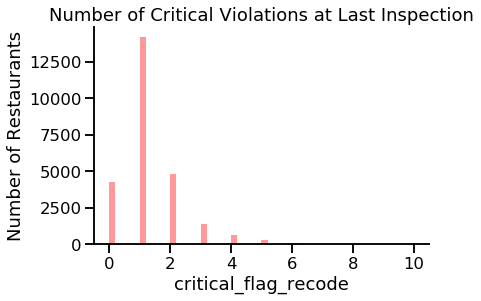

In [129]:
sns.set_context("talk")
sns.distplot(HD_LastInsp['critical_flag_recode'], kde=False, color='r')
sns.despine()
plt.title('Number of Critical Violations at Last Inspection')
plt.ylabel('Number of Restaurants')
#plt.xlim(0,40) 
#plt.savefig('histogram.png')